# 1d3v electron hybrid code for R/L-waves with stationary ions and homogeneoues background field

## 1. The model
The electron hybrid model for cold electrons with linearized fluid equations and hot kinetic electrons (Vlasov equation) reads

\begin{align}
&\frac{\partial\tilde{\mathbf{j}}_\mathrm{c}}{\partial t}=\epsilon_0\Omega_\mathrm{pe}^2\tilde{\mathbf{E}}+\tilde{\mathbf{j}}_\mathrm{c}\times\mathbf{\Omega}_\mathrm{ce}(\mathbf{x}),\\
&\frac{\partial f_\mathrm{h}}{\partial t}+\mathbf{v}\cdot\nabla f_\mathrm{h}+\frac{q_\mathrm{e}}{m_\mathrm{e}}(\mathbf{E}+\mathbf{v}\times\mathbf{B})\cdot\nabla_\mathbf{v}f_\mathrm{h}=0,\\
&\frac{\partial \tilde{\mathbf{B}}}{\partial t}=-\nabla\times\tilde{\mathbf{E}},\\
&\frac{1}{c^2}\frac{\partial \tilde{\mathbf{E}}}{\partial t}=\nabla\times\tilde{\mathbf{B}}-\mu_0\tilde{\mathbf{j}}_\mathrm{c}-\mu_0q_\mathrm{e}\int\mathbf{v}\tilde{f}_\mathrm{h}\,\mathrm{d}^3\mathbf{v},
\end{align}

where $\mathbf{\Omega}_\mathrm{ce}(\mathbf{x})=q_\mathrm{e}\mathbf{B}_0(\mathbf{x})/m_\mathrm{e}$ is the oriented electron cyclotron frequency corresponding to the background field $\mathbf{B}_0=\mathbf{B}_0(\mathbf{x})$ and $\Omega_{\mathrm{pe}}^2=n_{\mathrm{c}0}e^2/\epsilon_0m_\mathrm{e}$ the plasma frequency of the cold electrons. Here, only wave propagation parallel to the background magnetic field $\mathbf{B}_0=\mathbf{B}_0(\mathbf{x})$ is considered, i.e. $\textbf{k}=k\textbf{e}_z$. Therefore the nabla operator is simply $\nabla=\textbf{e}_z\partial_z$. The background magnetic field simply is $B(\mathbf{x})=B_0\mathbf{e}_z$.

We use periodic boundary conditions for all quantities.

## 2. The code

In [5]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import bsplines as bsp

import time

import utilitis_opt as utils_opt
import utilitis_pic


#====================================================================================
#  calling epyccel
#====================================================================================
from pyccel.epyccel import epyccel
utils_pic_fast = epyccel(utilitis_pic)
print('pyccelization of pic functions done!')
#====================================================================================



#===== saving data? (save = 1: yes, save = 0: no). If yes, name directory ===========
save = 0
title = 'test.txt' 
#====================================================================================



#===== save only every saving_step-th time step =====================================
saving_step = 1
#====================================================================================



#===== physical parameters ==========================================================
eps0 = 1.0                         # vacuum permittivity
mu0 = 1.0                          # vacuum permeability
c = 1.0                            # speed of light
qe = -1.0                          # electron charge
me = 1.0                           # electron mass
B0z = 1.0                          # minimum of background magnetic field in z-direction
wce = qe*B0z/me                    # electron cyclotron frequency
wpe = 2*np.abs(wce)                # cold electron plasma frequency
nuh = 0.06                         # ratio of cold/hot electron densities (nh/nc)
nh = nuh*wpe**2                    # hot electron density
wpar = 0.2*c                       # parallel thermal velocity of energetic particles
wperp = 0.53*c                     # perpendicular thermal velocity of energetic particles
#====================================================================================



#===== initial conditions ===========================================================
k = 2.                             # wavenumber of initial wave field perturbations
amp = 1e-4                         # amplitude of initial wave field perturbations
eps = 0.                           # amplitude of spatial pertubation of initial distribution function 


Ex0 = lambda z : 0*z               # initial Ex
Ey0 = lambda z : 0*z               # initial Ey
Bx0 = lambda z : amp*np.sin(k*z)   # initial Bx
By0 = lambda z : 0*z               # initial By
jx0 = lambda z : 0*z               # initial jcx
jy0 = lambda z : 0*z               # initial jcy
#====================================================================================



#===== numerical parameters =========================================================
Lz = 2*np.pi/k                     # length of z-domain
Nel = 32                           # number of elements z-direction
T = 200.                           # simulation time
dt = 0.05                          # time step
p = 3                              # degree of B-spline basis functions
Np = np.int(1e5)                   # number of markers
control = 1                        # control variate for noise reduction? (1: yes, 0: no)
time_integr = 1                    # do time integration? (1 : yes, 0: no)
#====================================================================================








#===== create parameter list ========================================================
pa = np.zeros(1*Nel + 5)

pa[0]  = eps0
pa[1]  = mu0
pa[2]  = c
pa[3]  = qe 
pa[4]  = me 
pa[5]  = B0z 
pa[6]  = wce 
pa[7]  = wpe 
pa[8]  = nuh 
pa[9]  = nh 
pa[10] = wpar 
pa[11] = wperp 
pa[12] = k  
pa[13] = amp 
pa[14] = eps 
pa[15] = Lz 
pa[16] = Nel 
pa[17] = T 
pa[18] = dt 
pa[19] = p 
pa[20] = Np
pa[21] = control
pa[22] = saving_step
#====================================================================================



#===== discretization of spatial domain =============================================
dz   = Lz/Nel                                # element size
el_b = np.linspace(0., Lz, Nel + 1)          # element boundaries

Nbase   = Nel + p                            # total number of basis functions
Nbase_0 = Nel                                # number of degrees of freedom
#====================================================================================



#===== some diagnostic values =======================================================
Eh_eq = Lz*nh*me/2*(wpar**2 + 2*wperp**2)    # equilibrium energetic electron energy

en_E = np.array([])                          # electric field energy
en_B = np.array([])                          # magnetic field energy
en_C = np.array([])                          # cold plasma energy
en_H = np.array([])                          # energetic electron energy
#====================================================================================



#===== system matrices for fluid electrons and electromagnetic fields ===============
A10 = np.array([0, 0, 0, +c**2, 0, 0])
A11 = np.array([0, 0, -c**2, 0, 0, 0])
A12 = np.array([0, -1, 0, 0, 0, 0])
A13 = np.array([+1, 0, 0, 0, 0, 0])
A14 = np.array([0, 0, 0, 0, 0, 0])
A15 = np.array([0, 0, 0, 0, 0, 0])
A1 = np.array([A10, A11, A12, A13, A14, A15])

A20 = np.array([0, 0, 0, 0, mu0*c**2, 0])
A21 = np.array([0, 0, 0, 0, 0, mu0*c**2])
A22 = np.array([0, 0, 0, 0, 0, 0])
A23 = np.array([0, 0, 0, 0, 0, 0])
A24 = np.array([-eps0*wpe**2, 0, 0, 0, 0, -wce])
A25 = np.array([0, -eps0*wpe**2, 0, 0, +wce, 0])
A2 = np.array([A20, A21, A22, A23, A24, A25])

s = int(np.sqrt(A1.size))
#====================================================================================



#===== initial energetic electron distribution function =============================
fh0 = lambda z, vx, vy, vz : (1 + eps*np.cos(k*z))*nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))
#====================================================================================


#===== Maxwellian for control variate ===============================================
maxwell = lambda vx, vy, vz : nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))
#====================================================================================


#===== sampling distribution for initial markers ====================================
g_sampling = lambda vx, vy, vz : 1/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))*1/Lz
#====================================================================================



#===== spline knot vector, mass and advection matrix ================================
Tz = bsp.make_knots(el_b, p, True)
M, C = utils_opt.matrixAssembly_V0(p, Nbase, Tz, True)

print('matrix assembly done!')
#====================================================================================



#===== initial coefficients with L2-projection ======================================
u0 = np.zeros((Nbase, s))

u0[:, 0] = utils_opt.L2_prod_V0(Ex0, p, Nbase, Tz)
u0[:, 1] = utils_opt.L2_prod_V0(Ey0, p, Nbase, Tz)
u0[:, 2] = utils_opt.L2_prod_V0(Bx0, p, Nbase, Tz)
u0[:, 3] = utils_opt.L2_prod_V0(By0, p, Nbase, Tz)
u0[:, 4] = utils_opt.L2_prod_V0(jx0, p, Nbase, Tz)
u0[:, 5] = utils_opt.L2_prod_V0(jy0, p, Nbase, Tz)

u0[:p] += u0[-p:]
u0 = u0[:u0.shape[0] - p]

u0 = np.linalg.solve(M, u0)
uj = np.reshape(u0, s*Nbase_0)

print('L2-projection of initial fields done!')
#====================================================================================



#===== construct block matrices =====================================================
M_block = np.kron(M, np.identity(6))
C_tilde = np.kron(C, A1)
M_tilde = np.kron(M, A2)

print('block matrices done!')
#====================================================================================



#===== create particles (z,vx,vy,vz,wk) and sample according to sampling distribution
particles = np.zeros((Np, 5), order='F')
particles[:, 0] = np.random.rand(Np)*Lz
particles[:, 1] = np.random.randn(Np)*wperp
particles[:, 2] = np.random.randn(Np)*wperp
particles[:, 3] = np.random.randn(Np)*wpar

jh = np.zeros(2*Nbase_0)
Fh = np.zeros(s*Nbase_0)

z_old = np.empty(Np)
#====================================================================================



#===== parameters for control variate ===============================================
g0 = g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
#====================================================================================



#===== initialize velocities by pushing back by -dt/2, compute weights and energy of hot particles
timea = time.time()

z_old[:] = particles[:, 0]

utils_pic_fast.borisPush_bc_1(particles, -dt/2, qe, me, Lz, Tz, p, Nbase_0, uj[0::s], uj[1::s], uj[2::s], uj[3::s], B0z)

particles[:, 0] = z_old
particles[:, 4] = w0 - control*maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0

timeb = time.time()
print('time for particle push: ' + str(timeb - timea))
#====================================================================================



#===== test timing for hot current computation ======================================
timea = time.time()

utils_pic_fast.hotCurrent_bc_1(particles[:, 1:3], particles[:, 0], particles[:, 4], Tz, p, Nbase_0, qe, jh)

timeb = time.time()
print('time for hot current computation: ' + str(timeb - timea))
#====================================================================================



#===== compute matrices for field update ============================================
LHS = sc.sparse.csc_matrix(M_block + 1/2*dt*C_tilde + 1/2*dt*M_tilde)
RHS = sc.sparse.csc_matrix(M_block - 1/2*dt*C_tilde - 1/2*dt*M_tilde)

LU = sc.sparse.linalg.splu(LHS)

print('LU factorization done!')
#====================================================================================



#===== test timing for linear solver ================================================
timea = time.time()

LU.solve(RHS.dot(uj) + dt*Fh)

timeb = time.time()
print('time for solving linear system: ' + str(timeb - timea))
#====================================================================================



#===== time integration by a time step dt =========================================== 
def update():
    # ... save old positions
    z_old = particles[:, 0]
    # ...
    
    
    # ... update particle velocities from n-1/2 to n+1/2 with fields at time n and positions from n to n+1 with velocities at n+1/2
    utils_pic_fast.borisPush_bc_1(particles, dt, qe, me, Lz, Tz, p, Nbase_0, uj[0::s], uj[1::s], uj[2::s], uj[3::s], B0z)
    # ...
    
    
    # ... update weights with control variate
    particles[:, 4] = w0 - control*maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0
    # ...
    
    
    # ... compute hot electron current densities
    utils_pic_fast.hotCurrent_bc_1(particles[:, 1:3], 1/2*(z_old + particles[:, 0]), particles[:, 4], Tz, p, Nbase_0, qe, jh)
    # ...
     
    
    # ... assemble right-hand side of weak formulation
    Fh[0::s] = -c**2*mu0*jh[0::2]
    Fh[1::s] = -c**2*mu0*jh[1::2]
    # ...
    
    
    # ... time integration of E, B, jc from n to n+1 with Crank-Nicolson method (use hot current density at n+1/2) 
    uj[:] = LU.solve(RHS.dot(uj) + dt*Fh)
    # ...
#====================================================================================





#===== create data file and save parameters (first row), initial fields and energies (second row)
if save == 1:
    file = open(title, 'ab')
    np.savetxt(file, np.reshape(pa, (1, 1*Nbase_0 + 5)), fmt = '%1.10e')

en_E = np.append(en_E, eps0/2*(np.dot(uj[0::s], np.dot(M, uj[0::s])) + np.dot(uj[1::s], np.dot(M, uj[1::s]))))
en_B = np.append(en_B, eps0/(2*mu0)*(np.dot(uj[2::s], np.dot(M, uj[2::s])) + np.dot(uj[3::s], np.dot(M, uj[3::s]))))
en_C = np.append(en_C, 1/(2*eps0*wpe**2)*(np.dot(uj[4::s], np.dot(M, uj[4::s])) + np.dot(uj[5::s], np.dot(M, uj[5::s]))))
en_H = np.append(en_H, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)

bx_save = np.append(np.copy(uj[2::s]), uj[2])

if save == 1:
    data = np.append(uj[2::s], np.array([en_E[-1], en_B[-1], en_C[-1], en_H[-1], 0.]))
    np.savetxt(file, np.reshape(data, (1, 1*Nbase_0 + 5)), fmt = '%1.10e')
#====================================================================================



#===== time integration =============================================================
if time_integr == 1:

    print('start time integration! (number of time steps : ' + str(int(T/dt)) + ')')
    time_step = 0

    while True:

        try:
            if time_step*dt >= T:
                if save == 1:
                    file.close()
                break

            if time_step%50 == 0:
                print('time steps finished: ' + str(time_step))

            update()

            if time_step%saving_step == 0:

                # ... add data to file
                en_E = np.append(en_E, eps0/2*(np.dot(uj[0::s], np.dot(M, uj[0::s])) + np.dot(uj[1::s], np.dot(M, uj[1::s]))))
                en_B = np.append(en_B, eps0/(2*mu0)*(np.dot(uj[2::s], np.dot(M, uj[2::s])) + np.dot(uj[3::s], np.dot(M, uj[3::s]))))
                en_C = np.append(en_C, 1/(2*eps0*wpe**2)*(np.dot(uj[4::s], np.dot(M, uj[4::s])) + np.dot(uj[5::s], np.dot(M, uj[5::s]))))
                en_H = np.append(en_H, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)

                bx_save = np.vstack((bx_save, np.append(np.copy(uj[2::s]), uj[2])))

                if save == 1:
                    data = np.append(uj[2::s], np.array([en_E[-1], en_B[-1], en_C[-1], en_H[-1], (time_step + 1)*dt]))
                    np.savetxt(file, np.reshape(data, (1, 1*Nbase_0 + 5)), fmt = '%1.10e')
                # ...

            time_step += 1
        except KeyboardInterrupt:
            print('Pausing...  (Hit ENTER to continue, type quit to exit.)')
            
            if save == 1:
                file.close()
            
            try:
                response = input()
                if response == 'quit':
                    break
                print('Resuming...')
                
                if save == 1:
                    file = open(title, 'ab')
                
            except KeyboardInterrupt:
                print('Resuming...')
                
                if save == 1:
                    file = open(title, 'ab')
                
                continue
                
    if save == 1:
        file.close()
#====================================================================================

pyccelization of pic functions done!
matrix assembly done!
L2-projection of initial fields done!
block matrices done!
time for particle push: 0.05168342590332031
time for hot current computation: 0.014675140380859375
LU factorization done!
time for solving linear system: 0.0004973411560058594
start time integration! (number of time steps : 4000)
time steps finished: 0
time steps finished: 50
time steps finished: 100
time steps finished: 150
time steps finished: 200
time steps finished: 250
time steps finished: 300
time steps finished: 350
time steps finished: 400
time steps finished: 450
time steps finished: 500
time steps finished: 550
time steps finished: 600
time steps finished: 650
time steps finished: 700
time steps finished: 750
time steps finished: 800
time steps finished: 850
time steps finished: 900
time steps finished: 950
time steps finished: 1000
time steps finished: 1050
time steps finished: 1100
time steps finished: 1150
time steps finished: 1200
time steps finished: 1250

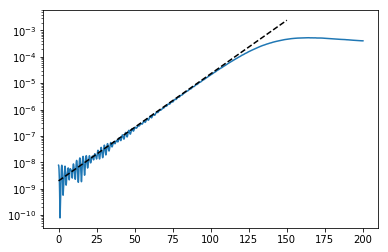

In [6]:
tn = np.linspace(0., T, len(en_B))
plt.semilogy(tn, en_B)

omega = utils_opt.solveDispersionHybrid(k, +1, c, wce, wpe, wpar, wperp, nuh, 0.5 + 0j, 1e-8)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)

t2 = np.linspace(0, 150, 100) 
plt.semilogy(t2, 2e-9*np.exp(gamma*2*t2), 'k--', label = 'expected growth')